In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import seaborn as sns

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tqdm import tqdm

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [5]:
all_pairs = pd.read_csv('all_pairs.csv')
all_pairs = [eval(x) for x in all_pairs.Target]
features = np.load('format_features.npy')[:,:-1]
features_with_class = np.load('format_features.npy')
edges = pd.read_csv('edges.csv')

In [6]:
def sample_edges(edges, num_nodes):
    length = int(len(edges))
    template = edges.iloc[:int(length/2)]
    template['is_connected'] = 1
    negative_source = np.random.randint(low=0, high=num_nodes+1, size=int(template.shape[0]))
    negative_target = np.random.randint(low=0, high=num_nodes+1, size=int(template.shape[0]))
    negative_samples = pd.DataFrame({'Target':negative_target, 'Source':negative_source})
    negative_samples['is_connected'] = 0
    return(template.append(negative_samples).sample(frac=1).drop_duplicates().reset_index(drop=True))

In [7]:
class DataSet(Dataset):
    def __init__(self, features, edges):
        self.edges = edges.to_numpy()
        self.features = features
        
    def __len__(self):
        return len(self.edges)

    def __getitem__(self, idx):
        row = self.edges[idx]
        first_feature = torch.tensor(self.features[row[0]-1]).float()
        second_feature = torch.tensor(self.features[row[1]-1]).float()
        target = torch.tensor(row[2])
        return first_feature, second_feature, target

In [8]:
sampled_edges = sample_edges(edges, len(features))
train_edges, test_edges = train_test_split(sampled_edges, test_size=0.15, random_state=42)

<ipython-input-6-70cd723a779f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  template['is_connected'] = 1


In [9]:
sampled_edges.is_connected

0        0
1        1
2        0
3        1
4        0
        ..
10547    0
10548    1
10549    0
10550    1
10551    1
Name: is_connected, Length: 10552, dtype: int64

In [10]:
train_dataset = DataSet(features, train_edges)
test_dataset = DataSet(features, test_edges)

In [11]:
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

In [12]:
class Net(torch.nn.Module):
    def __init__(self, num_features, nn1 , nn2):
        super(Net, self).__init__()        
        lin1 = nn.Linear(num_features,nn1)
        bn1 = nn.BatchNorm1d(nn1)
        lin2 = nn.Linear(nn1, nn2)
        bn2 = nn.BatchNorm1d(nn2)
        lin3 = nn.Linear(num_features,nn1)
        lin4 = nn.Linear(nn1, nn2)
        dropout = nn.Dropout(p=0.5)
        self.encoder1 = nn.Sequential(lin1, nn.ReLU(), bn1, lin2, nn.ReLU(), dropout)
        self.encoder2 = nn.Sequential(lin3, nn.ReLU(), bn1, lin4, nn.ReLU(), dropout)
        self.fin_layer = nn.Linear(nn2,1)
    def forward(self, first_node, second_node):
        y1 = self.encoder1(first_node.to(device))
        y2 = self.encoder2(second_node.to(device))
        z =  torch.abs(y1-y2)
        z = self.fin_layer(z)    
        return z.squeeze()
    def computeLoss(self, predict, true_value):
        pos_weight = sum(true_value)/(sum((true_value==0).int()))
        loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        output = loss(predict.to(device), true_value.to(device))
        return(output)

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net(1433, 1200, 600)
model = model.to(device)
optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-4)

In [14]:
q = next(iter(train_dataloader))
a = q[0]
b = q[1]
c = q[2].float()
model.computeLoss(model.forward(a,b),c)

tensor(0.7206, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

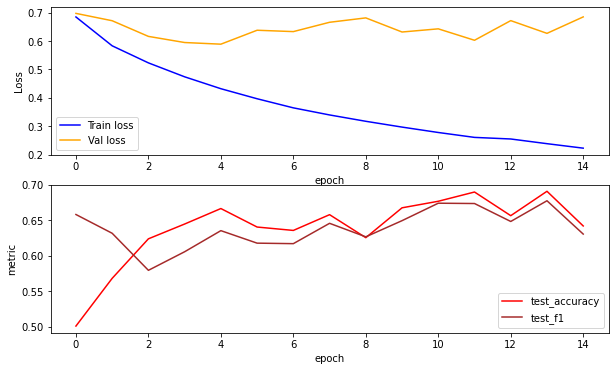

In [15]:
num_epochs = 15
train_losses = []
val_losses = []
accs = []
f1s = []
for i in range(num_epochs):
    model.train(False)
    epoch_test_loss = 0
    acc=0
    f1=0
    t = 0
    sigm = nn.Sigmoid()
    for ff, sf, target in test_dataloader:
        predict = model.forward(ff, sf).float()
        loss = model.computeLoss(predict, target.float())
        t+=1
        epoch_test_loss+=loss
        format_predict = (sigm(predict)>0.5).int().cpu()
        acc += accuracy_score(format_predict, target)
        f1 += f1_score(format_predict, target)
    acc/=t
    f1/=t
    accs.append(acc)
    f1s.append(f1)
    epoch_test_loss/=t
    val_losses.append(epoch_test_loss)
    model.train(True)
    epoch_train_loss = 0
    t = 0
    for ff, sf, target in train_dataloader:
        optimizer1.zero_grad()
        predict = model.forward(ff, sf).float()
        loss = model.computeLoss(predict, target.float())
        loss.backward()
        optimizer1.step()
        t+=1
        epoch_train_loss+=loss
    epoch_train_loss/=t
    train_losses.append(epoch_train_loss)
    clear_output()
    plt.figure(figsize = (10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label = 'Train loss', color = 'blue')
    plt.plot(val_losses, label = 'Val loss', color = 'orange')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(accs, label = 'test_accuracy', color = 'red')
    plt.plot(f1s, label = 'test_f1', color = 'brown')
    plt.xlabel('epoch')
    plt.ylabel('metric')
    plt.legend()
    plt.show()

In [16]:
accs

[0.5011947307180851,
 0.5684217087765957,
 0.6240857712765957,
 0.6449260305851063,
 0.666742852393617,
 0.6406873337765957,
 0.6359084109042553,
 0.6581096243351063,
 0.6257064494680851,
 0.6677713597074468,
 0.676996758643617,
 0.6900245179521276,
 0.6566967253989362,
 0.6910530252659575,
 0.6422041223404256]

In [17]:
from networkx.algorithms.traversal.breadth_first_search import bfs_edges as bfs

In [18]:
import networkx as nx

In [19]:
G = nx.Graph()

In [20]:
for i in range(len(features)):
    G.add_node(i)

In [21]:
G.add_edges_from(np.array(edges))

In [49]:
root = 100
generated_edges = bfs(G, root, depth_limit=4)
generated_edges
generated_edges = list(generated_edges)

In [50]:
nodes_in_graph = np.array([root] + [v for n, v in generated_edges])

In [51]:
len(nodes_in_graph)

432

In [52]:
order = set(list(range(len(features)))) - set(nodes_in_graph)
order = list(order)
np.random.shuffle(order)

In [53]:
len(generated_edges)

431

In [54]:
import time

In [55]:
time.time()-time.time()

0.0

In [56]:
sigm = nn.Sigmoid()
predicts = []
times = []
n = []
for i in tqdm(order):
    start_time = time.time()
    first_node_features = torch.tensor([features[x] for x in range(len(nodes_in_graph))]).float()
    second_node_features = torch.tensor(features[nodes_in_graph]).float()
    predict = sigm(model.forward(first_node_features, second_node_features)).cpu()
    predicts += list(predict.detach().numpy())
    nodes_in_graph = np.append(nodes_in_graph, i)
    end_time = time.time()
    n.append(len(nodes_in_graph))
    times.append(end_time-start_time)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2276/2276 [08:53<00:00,  4.27it/s]


Text(0, 0.5, 'Секунды')

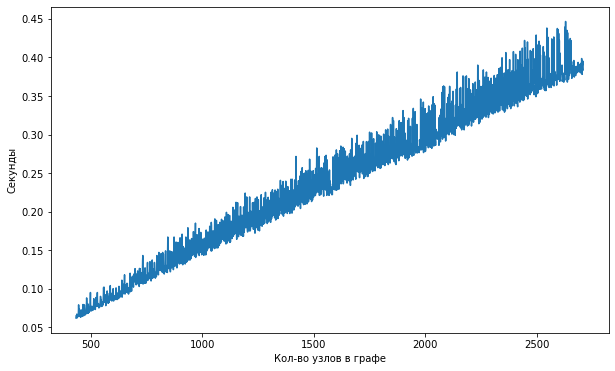

In [30]:
plt.figure(figsize = (10, 6))
sns.lineplot(n, times)
plt.xlabel("Кол-во узлов в графе")
plt.ylabel("Секунды")

In [36]:
for i in np.linspace(0.9909,0.99099045, 200):
    t = ( np.array(predicts)>=i).astype(int).sum()
    print(i, t)

0.9909 6865
0.9909004545226131 6865
0.9909009090452261 6865
0.9909013635678392 6865
0.9909018180904523 6865
0.9909022726130653 6865
0.9909027271356784 6865
0.9909031816582915 6865
0.9909036361809045 6865
0.9909040907035176 6865
0.9909045452261307 6865
0.9909049997487437 6865
0.9909054542713568 6865
0.9909059087939699 6865
0.9909063633165829 6865
0.990906817839196 6865
0.9909072723618091 6865
0.9909077268844221 6865
0.9909081814070352 6865
0.9909086359296483 6865
0.9909090904522613 6865
0.9909095449748744 6865
0.9909099994974875 6865
0.9909104540201005 6865
0.9909109085427136 6865
0.9909113630653267 6865
0.9909118175879397 6865
0.9909122721105528 6865
0.9909127266331659 6865
0.9909131811557789 6865
0.990913635678392 6865
0.9909140902010051 6865
0.9909145447236181 6865
0.9909149992462312 6865
0.9909154537688443 6865
0.9909159082914573 6865
0.9909163628140704 6865
0.9909168173366835 6865
0.9909172718592965 6865
0.9909177263819096 6865
0.9909181809045227 6865
0.9909186354271357 6865
0.9909

In [37]:
root = 100
generated_edges = bfs(G, root, depth_limit=4)
generated_edges
generated_edges = list(generated_edges)

In [38]:
nodes_in_graph = np.array([root] + [v for n, v in generated_edges])

In [39]:
order = set(list(range(len(features)))) - set(nodes_in_graph)
order = list(order)
np.random.shuffle(order)

In [40]:
len(generated_edges)

431

In [33]:
import time

In [41]:
den = []
sigm = nn.Sigmoid()
for i in (order):
    first_node_features = torch.tensor([features[x] for x in range(len(nodes_in_graph))]).float()
    second_node_features = torch.tensor(features[nodes_in_graph-1]).float()
    predict = sigm(model.forward(first_node_features, second_node_features))
    predict = predict>0.9909468158291457
    connected_with = nodes_in_graph[predict.cpu()]
    new_edges = [(i, x) for x in connected_with]
    generated_edges+=new_edges
    nodes_in_graph = np.append(nodes_in_graph, i)
    print(len(nodes_in_graph), len(generated_edges))
    den.append((len(nodes_in_graph), len(generated_edges)))

433 431
434 431
435 431
436 431
437 431
438 431
439 431
440 431
441 431
442 431
443 431
444 431
445 431
446 431
447 431
448 431
449 431
450 431
451 431
452 431
453 431
454 431
455 431
456 431
457 431
458 431
459 431
460 431
461 431
462 431
463 431
464 431
465 431
466 431
467 431
468 431
469 431
470 431
471 431
472 431
473 431
474 431
475 431
476 431
477 431
478 431
479 431
480 431
481 431
482 431
483 431
484 431
485 431
486 431
487 431
488 431
489 431
490 431
491 431
492 431
493 431
494 431
495 431
496 431
497 431
498 431
499 431
500 431
501 431
502 431
503 431
504 431
505 431
506 431
507 431
508 431
509 431
510 431
511 431
512 431
513 431
514 431
515 431
516 431
517 431
518 431
519 431
520 431
521 431
522 431
523 431
524 431
525 431
526 431
527 431
528 431
529 431
530 431
531 431
532 431
533 431
534 431
535 431
536 431
537 431
538 431
539 431
540 431
541 431
542 431
543 431
544 431
545 431
546 431
547 431
548 431
549 431
550 431
551 431
552 431
553 431
554 431
555 431
556 431
557 431


1397 1081
1398 1082
1399 1083
1400 1084
1401 1085
1402 1086
1403 1087
1404 1088
1405 1089
1406 1090
1407 1091
1408 1092
1409 1093
1410 1094
1411 1095
1412 1096
1413 1097
1414 1098
1415 1099
1416 1100
1417 1101
1418 1102
1419 1103
1420 1104
1421 1105
1422 1106
1423 1107
1424 1108
1425 1109
1426 1110
1427 1111
1428 1112
1429 1113
1430 1114
1431 1115
1432 1116
1433 1117
1434 1118
1435 1119
1436 1120
1437 1121
1438 1122
1439 1123
1440 1124
1441 1125
1442 1126
1443 1127
1444 1128
1445 1129
1446 1130
1447 1131
1448 1132
1449 1133
1450 1134
1451 1135
1452 1136
1453 1137
1454 1138
1455 1139
1456 1140
1457 1141
1458 1142
1459 1143
1460 1145
1461 1147
1462 1149
1463 1151
1464 1153
1465 1155
1466 1157
1467 1159
1468 1161
1469 1163
1470 1165
1471 1167
1472 1169
1473 1171
1474 1173
1475 1175
1476 1177
1477 1179
1478 1181
1479 1183
1480 1185
1481 1187
1482 1189
1483 1191
1484 1193
1485 1195
1486 1197
1487 1199
1488 1201
1489 1203
1490 1205
1491 1207
1492 1209
1493 1211
1494 1213
1495 1215
1496 1217


2217 3894
2218 3898
2219 3902
2220 3906
2221 3910
2222 3914
2223 3918
2224 3922
2225 3926
2226 3930
2227 3934
2228 3938
2229 3942
2230 3946
2231 3950
2232 3954
2233 3958
2234 3962
2235 3966
2236 3970
2237 3974
2238 3978
2239 3982
2240 3986
2241 3990
2242 3994
2243 3998
2244 4002
2245 4006
2246 4010
2247 4014
2248 4018
2249 4022
2250 4026
2251 4030
2252 4034
2253 4038
2254 4042
2255 4046
2256 4050
2257 4054
2258 4058
2259 4062
2260 4066
2261 4070
2262 4074
2263 4078
2264 4082
2265 4086
2266 4090
2267 4094
2268 4098
2269 4102
2270 4106
2271 4110
2272 4114
2273 4118
2274 4122
2275 4126
2276 4130
2277 4134
2278 4138
2279 4142
2280 4146
2281 4150
2282 4154
2283 4158
2284 4162
2285 4166
2286 4170
2287 4174
2288 4178
2289 4182
2290 4186
2291 4190
2292 4194
2293 4198
2294 4202
2295 4206
2296 4210
2297 4214
2298 4218
2299 4222
2300 4226
2301 4230
2302 4234
2303 4238
2304 4242
2305 4246
2306 4250
2307 4254
2308 4258
2309 4262
2310 4266
2311 4270
2312 4274
2313 4278
2314 4282
2315 4286
2316 4290


In [42]:
den

[(433, 431),
 (434, 431),
 (435, 431),
 (436, 431),
 (437, 431),
 (438, 431),
 (439, 431),
 (440, 431),
 (441, 431),
 (442, 431),
 (443, 431),
 (444, 431),
 (445, 431),
 (446, 431),
 (447, 431),
 (448, 431),
 (449, 431),
 (450, 431),
 (451, 431),
 (452, 431),
 (453, 431),
 (454, 431),
 (455, 431),
 (456, 431),
 (457, 431),
 (458, 431),
 (459, 431),
 (460, 431),
 (461, 431),
 (462, 431),
 (463, 431),
 (464, 431),
 (465, 431),
 (466, 431),
 (467, 431),
 (468, 431),
 (469, 431),
 (470, 431),
 (471, 431),
 (472, 431),
 (473, 431),
 (474, 431),
 (475, 431),
 (476, 431),
 (477, 431),
 (478, 431),
 (479, 431),
 (480, 431),
 (481, 431),
 (482, 431),
 (483, 431),
 (484, 431),
 (485, 431),
 (486, 431),
 (487, 431),
 (488, 431),
 (489, 431),
 (490, 431),
 (491, 431),
 (492, 431),
 (493, 431),
 (494, 431),
 (495, 431),
 (496, 431),
 (497, 431),
 (498, 431),
 (499, 431),
 (500, 431),
 (501, 431),
 (502, 431),
 (503, 431),
 (504, 431),
 (505, 431),
 (506, 431),
 (507, 431),
 (508, 431),
 (509, 431),

In [43]:
num_nodes = np.array(den)[::,0]
num_edges = np.array(den)[::,1]

In [44]:
should_be = 2.05*num_nodes/(num_nodes*(num_nodes-1))

In [45]:
how_is = 2*num_edges/(num_nodes*(num_nodes-1))

In [46]:
how_is

array([0.00460825, 0.00458701, 0.00456592, ..., 0.00167274, 0.00167287,
       0.001673  ])

In [47]:
should_be

array([0.00474537, 0.00473441, 0.0047235 , ..., 0.00075786, 0.00075758,
       0.0007573 ])

Text(0, 0.5, 'density')

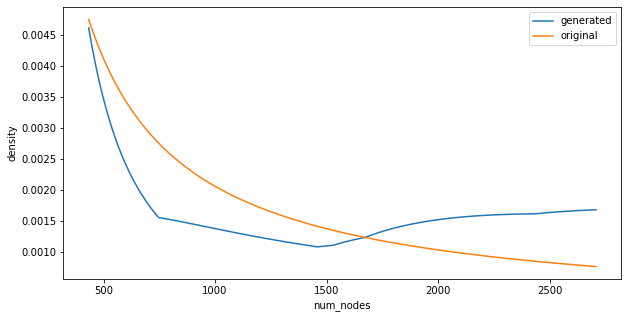

In [48]:
plt.figure(figsize = (10, 5))
sns.lineplot(x=num_nodes, y=how_is, label='generated')
sns.lineplot(x=num_nodes, y=should_be, label='original')
plt.xlabel('num_nodes')
plt.ylabel('density')

In [122]:
q = np.append(np.array(generated_edges)[:,0], np.array(generated_edges)[:,1])

In [123]:
nodes_in_graph = nodes_in_graph[[x in q for x in nodes_in_graph]]

In [124]:
len(generated_edges)

1617652

In [125]:
# from metrics2 import metrics

In [126]:
temp = np.array(generated_edges)

In [127]:
np.array(generated_edges)[:, ::-1]

array([[1611,  100],
       [ 265,  100],
       [ 758,  100],
       ...,
       [2593, 1758],
       [ 819, 1758],
       [1680, 1758]], dtype=int64)

In [128]:
ge = np.append(temp,np.array(generated_edges)[:, ::-1], axis=0)

In [130]:
met = metrics(ge, np.array(edges))

KeyboardInterrupt: 

In [ ]:
met.full_output()

In [42]:
nodes_in_graph.shape

(2248,)

In [247]:
classes = features_with_class[nodes_in_graph][:,-1]

In [239]:
P = nx.Graph()

In [240]:
for i in nodes_in_graph:
    P.add_node(i)

In [241]:
P.add_edges_from(ge)

In [249]:
colours = {0:'red', 1:'blue', 2:'green',3:'yellow', 4:'grey', 5:'orange',6:'black'}
labs = [colours[x] for x in classes]

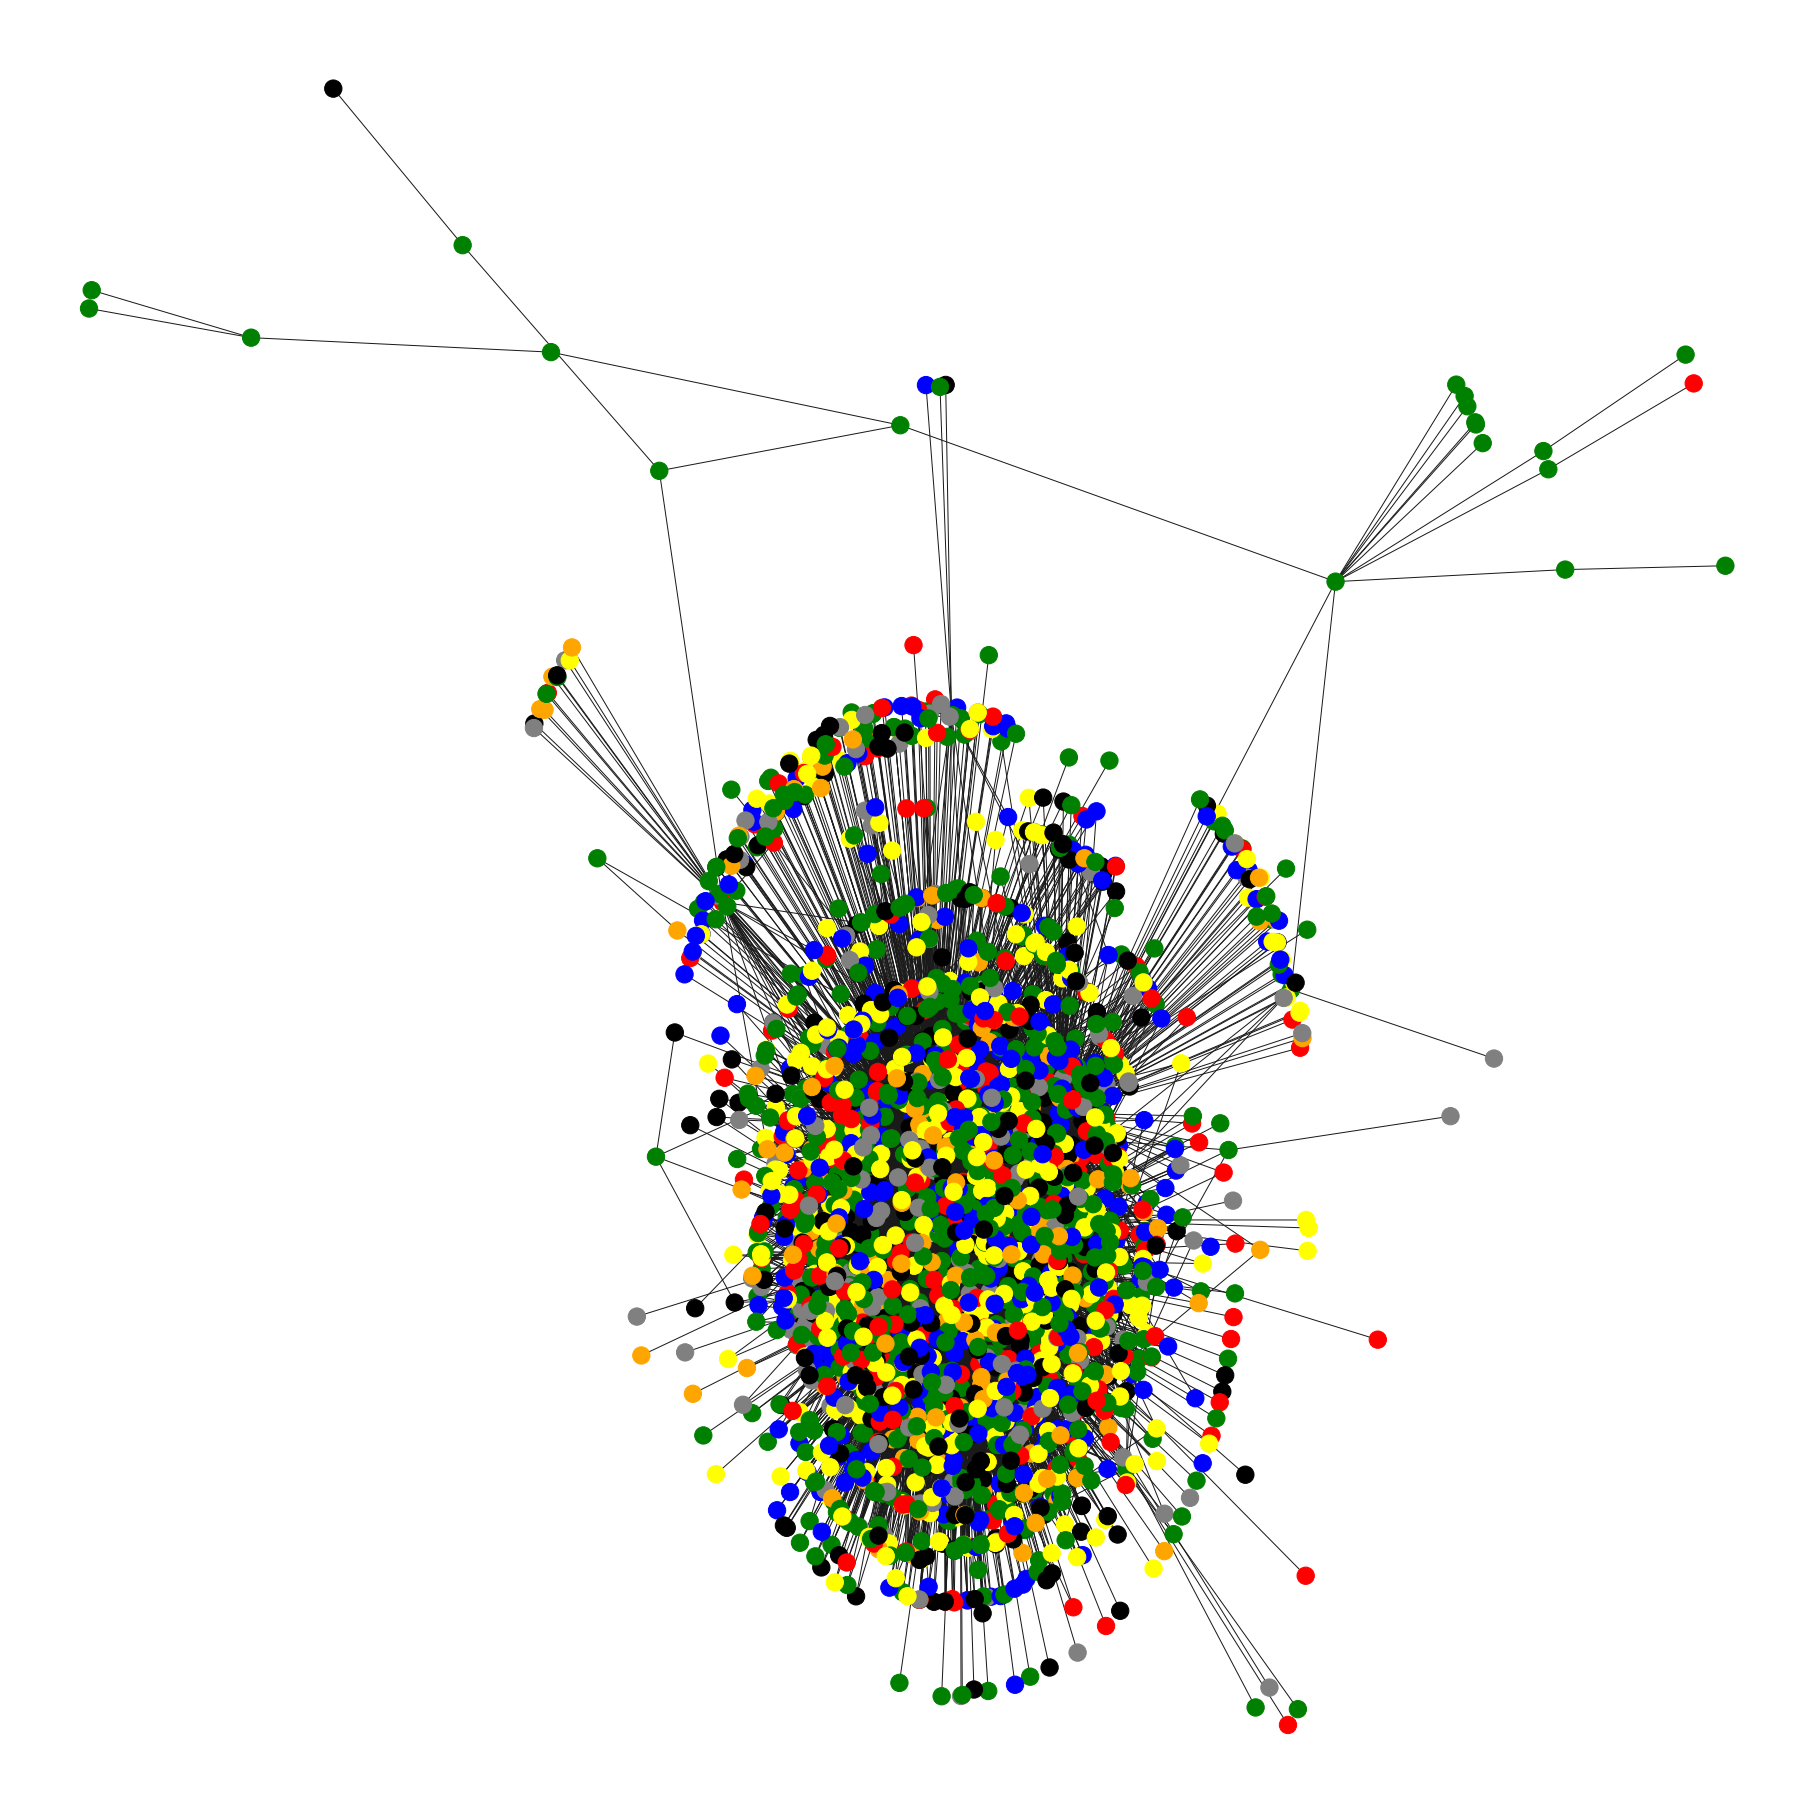

In [251]:
plt.figure(figsize = (25, 25))
nx.draw(P, node_color=labs)

In [113]:
class metrics:
    def __init__(self, first_graph, second_graph):
        self.first_graph = first_graph
        self.second_graph = second_graph

        self.degrees, self.first_graph_deg_count, self.second_graph_deg_count = \
            self.get_format_distributions(first_graph, second_graph)

        self.kl_d_dist = self.get_kl_divergence(self.first_graph_deg_count, self.second_graph_deg_count)
        self.KLd = self.kl_d_dist.sum()

        self.first_average_clustering = self.get_av_clustering(first_graph)
        self.second_average_clustering = self.get_av_clustering(second_graph)
        self.av_clustering_diff = abs(self.first_average_clustering - self.second_average_clustering)

        self.first_density = self.get_density(first_graph)
        self.second_density = self.get_density(second_graph)
        self.density_diff = self.first_density - self.second_density

    def full_output(self):
        print("KLd = ", self.KLd)
        print("av_clustering_diff = ", self.av_clustering_diff)
        print("density_diff = ", self.density_diff)
        self.visual()

    def get_density(self, graph):
        g = len(np.unique(graph[:, 0]))
        l = len(graph)
        return (2 * l / ((g ** 2) - g))

    def get_av_clustering(self, graph):
        G = nx.Graph()
        for i in range(len(np.unique(graph[:, 0]))):
            G.add_node(i)
        G.add_edges_from(np.array(graph))
        #         clusterings = nx.clustering(G)
        #         frame = pd.DataFrame({'node':list(range(len(clusterings))),
        #                 'clustering_coef':list(clusterings.values())})

        return nx.average_clustering(G)

    def get_kl_divergence(self, first_dist, second_dist):
        p1 = first_dist / first_dist.sum()
        p1 += 0.000001
        p2 = second_dist / second_dist.sum()
        p2 += 0.000001
        res = p1 * np.log(p1 / p2)
        return (res)

    def get_format_distributions(self, first_graph, second_graph):
        first_graph_deg, first_graph_deg_count = self.get_distribution(first_graph)
        second_graph_deg, second_graph_deg_count = self.get_distribution(second_graph)
        max_len = max((max(first_graph_deg), (max(second_graph_deg))))
        format_first_graph_deg_count = np.zeros(max_len)
        format_first_graph_deg_count[np.array(first_graph_deg) - 1] = first_graph_deg_count
        format_second_graph_deg_count = np.zeros(max_len)
        format_second_graph_deg_count[np.array(second_graph_deg) - 1] = second_graph_deg_count
        return ((np.arange(max_len) + 1).astype(int), format_first_graph_deg_count.astype(int),
                format_second_graph_deg_count.astype(int))

    def get_distribution(self, graph):
        graph = pd.DataFrame(graph.tolist()).rename(columns={0: 'source', 1: 'target'})
        graph['degree'] = 1
        graph_degrees = graph.groupby('source').agg({'degree': 'count'})
        graph_degrees = graph_degrees.groupby('degree').agg({'degree': 'count'})
        return (list(graph_degrees.index), list(graph_degrees.degree))

    def visual(self, full_size=False):
        if full_size:
            last_index = 500
        else:
            last_index = 30
        f, ax = plt.subplots(figsize=(15, 15))
        plt.subplot(2, 1, 1)
        sns.set_color_codes("dark")
        sns.barplot(x=self.degrees[:last_index], y=self.first_graph_deg_count[:last_index],
                    label="Синтетический", color="r", alpha=0.5)
        sns.lineplot(x=self.degrees[:last_index] - 1, y=self.first_graph_deg_count[:last_index], color='r')
        sns.set_color_codes("bright")
        sns.barplot(x=self.degrees[:last_index], y=self.second_graph_deg_count[:last_index],
                    label="Оригинальный", color="b", alpha=0.5)
        sns.lineplot(x=self.degrees[:last_index] - 1, y=self.second_graph_deg_count[:last_index], color="b")
        plt.xlabel("degree")
        plt.ylabel("count")
        plt.xticks(rotation=-45, ticks=(self.degrees[0:last_index:100]), labels = (self.degrees[0:last_index:100]-1))
        plt.subplot(2, 1, 2)
        sns.lineplot(x=self.degrees[:last_index] - 1, y=self.kl_d_dist[:last_index], color="black",
                     label='KL')
        plt.xlabel("degree")
        plt.ylabel("KL_value")
        plt.legend(ncol=2, loc="upper right", frameon=True)
        plt.xticks(rotation=-45)